In [20]:
# 20/02/2023

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import pickle


import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, plot_confusion_matrix

In [22]:
class ShaoXing:

    def __init__(self):
        
        self._initialise_objects()

        print('ShaoXing Initialised')



    def _initialise_objects(self):
        """ Helper to initialise objects in ShaoXing """

        self._seed = 18980305
        self.features = None
        self.label = None
        self.full_data = None
        self.train_data = None
        self.val_data = None
        self.test_data = None
        self.train_x = None
        self.train_y = None
        self.val_x = None
        self.val_y = None
        self.test_x = None
        self.test_y = None
        self.future_data = None
        self.train_analyse_df = None
        self.val_analyse_df = None
        self.test_analyse_df = None
        self._train_residual_analyse_df = None
        self._val_residual_analyse_df = None
        self._test_residual_analyse_df = None
        self._train_residual_plot_objects = dict()
        self._val_residual_plot_objects = dict()
        self._test_residual_plot_objects = dict()
        self._model_fitted = 0
        self._model_class = None
        self._clf_type = None
        self._parameters = None
        self._model_class_type = None
        self._model_name = None
        self.model = None
        self._model_fit_time = None
        self.future_pred = None
        self.future_data_and_pred = None
        self._train_pred = None
        self._val_pred = None
        self._test_pred = None
        self.regular_stats_df = None
        self.CV_stats_df = None
        self.RESIDUAL_PLOT_OBJECTS = None
        self._RESIDUAL_ANALYSE_DF = None
        self.feature_importance_df = None
        self.train_analyse_df = None



    def read_in_features_label(self, features, label):
        """ Reads in features list and label for this classifier """

        self.features = features
        self.label = label



    def read_in_full_train_test_data(self, full_data, train_data, val_data, test_data):
        """ Read in Full, Train, Validate, Test data, auto transforming to X, y """

        if self.features == None or self.label == None:
            print("Missing features list and label. Please run .read_in_features_label before running this function")
            return

        for col in self.features:
            assert col in full_data.columns
            assert col in train_data.columns
            assert col in val_data.columns
            assert col in test_data.columns


        self.full_data = full_data
        print('Full Data read in successfully')
        self.train_data = train_data
        print('Train Data read in successfully')
        self.val_data = val_data
        print('Validation Data read in successfully')
        self.test_data = test_data
        print('Test Data read in successfully')


        self.train_x, self.train_y = self._separate_feature_label(train_data)
        self.val_x, self.val_y = self._separate_feature_label(val_data)
        self.test_x, self.test_y = self._separate_feature_label(test_data)
    


    def _separate_feature_label(self, data):
        """ Helper that returns data with just the feature columns and data with just the label column """

        return data[self.features], data[self.label]



    def read_in_future_data(self, future_data):
        """ Read in future data """

        assert len(future_data.columns) in (len(self.features), len(self.features)+ 1)

        for col in self.features:
            assert col in future_data.columns
        
        self.future_pred = None # reset future predictions given new data
        self.future_data_and_pred = None

        self.future_data = future_data
        print('Future Data read in successfully')


    
    def read_in_untrained_model(self, model_class, best_params, type, model_class_type, model_name):
        """ Reads in underlying model class object for tuning, and also read in what type of model it is and its name (arbitary) """

        assert type == 'Classification' or type == 'Regression' # check

        # record
        self._model_fitted = 0
        self._model_class = model_class
        self._clf_type = type 
        self._parameters = best_params
        self._model_class_type = model_class_type
        self._model_name = model_name

        print(f'Successfully read in untrained model {self._model_class} with hyper_parameters {self._parameters}, which is a {self._clf_type} model')
    

    
    def read_in_fitted_model(self, fitted_model, type, model_class_type, model_name):
        """ Reads in a fitted model """

        assert type == 'Classification' or type == 'Regression' # check
        
        self.model = fitted_model
        self._clf_type = type
        self._model_class_type = model_class_type
        self._model_name = model_name
        
        self._model_fitted = 1

        print(f'Successfully read in fitted model {self.model}, which is a {self._clf_type} model')


    
    def fit_model(self):
        """ Fit the model based on train x and train y for the model class with the previously inputted hyper_parameters """

        if self._model_class == None or self._parameters == None:
            print('Missing _model_class or hyper_parameters, please run .read_in_untrained_model()')

        start = time.time()
        self.model = self._model_class(**self._parameters)
        self.model.fit(self.train_x, self.train_y)
        end = time.time()

        self._model_fit_time = end - start

        self._model_fitted = 1
        print(f'Model fitted, taking {self._model_fit_time} seconds')



    def export_model(self, model_export_address):
        """ Exports the model as a .pickle """

        if self._model_fitted == 0:
            print('Please fit model using .fit_model() before exporting')
            return
        
        model_export_address_strip = model_export_address.split('.pickle')[0]

        with open(f'{model_export_address_strip}.pickle', 'wb') as f:
            pickle.dump(self.model, f)
    


    def predict_using_future_data(self, return_pred = False):
        """ Make predictions for future x data """

        if self._model_fitted == 0:
            print('Model not fitted, please use .read_in_fitted_model() to read in a fitted model or .fit_model() to fit model')
            return

        if self.future_data is None:
            print('No future data found, please run .read_in_future_data()')
            return

        self.future_pred = self.model.predict(self.future_data)

        if return_pred:
            return self.future_pred
        

    
    def export_future_data_and_predictions(self, future_data_and_pred_saving_address):
        """ Helper to export future predictions (with the x) """

        assert self.future_pred

        self.future_data_and_pred = copy.deepcopy(self.future_data)
        self.future_data_and_pred['Pred'] = self.future_pred

        future_data_and_pred_saving_address_strip = future_data_and_pred_saving_address.split('.csv')[0]
            
        self.future_data_and_pred.to_csv(f'{future_data_and_pred_saving_address_strip}.csv', index=False)

    

    def view_future_data_and_predictions(self, return_df = False):
        """ Function to view the future predictions and data """

        if self.future_data_and_pred == None:
            self.future_data_and_pred = copy.deepcopy(self.future_data)
            self.future_data_and_pred['Pred'] = self.future_pred
        
        if return_df:
            return self.future_data_and_pred
        else:
            display(self.future_data_and_pred)
    
    

    def get_analysis(self, address = None):
        """ Function that calculates and displays the summary statistics for the model for both train, val and test data; including graphs and cross validated data """

        self._train_pred = self.model.predict(self.train_x)
        self._val_pred = self.model.predict(self.val_x)
        self._test_pred = self.model.predict(self.test_x)

        # Normal stats
        if self._clf_type == 'Regression':
            train_score = np.round(r2_score(self.train_y, self._train_pred), 4)
            val_score = np.round(r2_score(self.val_y, self._val_pred), 4)
            test_score = np.round(r2_score(self.test_y, self._test_pred), 4)

            train_rmse = np.round(np.sqrt(mean_squared_error(self.train_y, self._train_pred)), 4)
            val_rmse = np.round(np.sqrt(mean_squared_error(self.val_y, self._val_pred)), 4)
            test_rmse = np.round(np.sqrt(mean_squared_error(self.test_y, self._test_pred)), 4)

            train_mape = np.round(mean_absolute_percentage_error(self.train_y, self._train_pred), 4)
            val_mape = np.round(mean_absolute_percentage_error(self.val_y, self._val_pred), 4)
            test_mape = np.round(mean_absolute_percentage_error(self.test_y, self._test_pred), 4)


            # Quartile Stats:
            train_quantile4_n, train_quantile4_r2, train_quantile4_RMSE, \
                train_quantile4_MAPE, val_quantile4_n, val_quantile4_r2, \
                    val_quantile4_RMSE, val_quantile4_MAPE, test_quantile4_n, \
                        test_quantile4_r2, test_quantile4_RMSE, test_quantile4_MAPE = \
                            self._quantily_stats(4)
            
            train_quantile10_n, train_quantile10_r2, train_quantile10_RMSE, \
                train_quantile10_MAPE, val_quantile10_n, val_quantile10_r2, \
                    val_quantile10_RMSE, val_quantile10_MAPE, test_quantile10_n, \
                        test_quantile10_r2, test_quantile10_RMSE, test_quantile10_MAPE = \
                            self._quantily_stats(10)
            
            # CV
            train_cv_r2_score, train_cv_rmse_score, train_cv_mape_score, \
                test_cv_r2_score, test_cv_rmse_score, test_cv_mape_score = self._get_CV_stats()

            # Diagram
            self._get_residual_plots()

            regular_stats_index = ['R2', 'RMSE'] 
            # regular_stats_index.append('MAPE')
            regular_stats_index.extend([f'Q4 n {n+1}' for n in range(4)])
            regular_stats_index.extend([f'Q4 R2 {n+1}' for n in range(4)])
            regular_stats_index.extend([f'Q4 RMSE {n+1}' for n in range(4)])
            # regular_stats_index.extend([f'Q4 MAPE {n+1}' for n in range(4)])
            regular_stats_index.extend([f'Q10 n {n+1}' for n in range(10)])
            regular_stats_index.extend([f'Q10 R2 {n+1}' for n in range(10)])
            regular_stats_index.extend([f'Q10 RMSE {n+1}' for n in range(10)])
            # regular_stats_index.extend([f'Q10MAPE {n+1}' for n in range(10)])

            train_stats = [train_score, train_rmse]
            # train_stats.append(train_mape)
            train_stats.extend(train_quantile4_n) 
            train_stats.extend(train_quantile4_r2) 
            train_stats.extend(train_quantile4_RMSE) 
            # train_stats.extend(train_quantile4_MAPE) 
            train_stats.extend(train_quantile10_n) 
            train_stats.extend(train_quantile10_r2) 
            train_stats.extend(train_quantile10_RMSE) 
            # train_stats.extend(train_quantile10_MAPE)

            val_stats = [val_score, val_rmse]
            # val_stats.append(val_mape)
            val_stats.extend(val_quantile4_n) 
            val_stats.extend(val_quantile4_r2) 
            val_stats.extend(val_quantile4_RMSE) 
            # val_stats.extend(val_quantile4_MAPE) 
            val_stats.extend(val_quantile10_n) 
            val_stats.extend(val_quantile10_r2) 
            val_stats.extend(val_quantile10_RMSE) 
            # val_stats.extend(val_quantile10_MAPE)

            test_stats = [test_score, test_rmse]
            # test_stats.append(test_mape)
            test_stats.extend(test_quantile4_n) 
            test_stats.extend(test_quantile4_r2) 
            test_stats.extend(test_quantile4_RMSE) 
            # test_stats.extend(test_quantile4_MAPE) 
            test_stats.extend(test_quantile10_n) 
            test_stats.extend(test_quantile10_r2) 
            test_stats.extend(test_quantile10_RMSE) 
            # test_stats.extend(test_quantile10_MAPE)

            cv_stats_index = ['CV R2', 'CV RMSE']
            # cv_stats_index.append('CV MAPE')
            cv_train_stats = [train_cv_r2_score, train_cv_rmse_score]
            # cv_train_stats.append(train_cv_mape_score)
            cv_test_stats = [test_cv_r2_score, test_cv_rmse_score]
            # cv_test_stats.append(test_cv_mape_score)

            self.regular_stats_df = pd.DataFrame({'Train': train_stats, 'Validation': val_stats, 'Test': test_stats}, index = regular_stats_index)
            self.CV_stats_df = pd.DataFrame({'CV Train': cv_train_stats, 'CV Test': cv_test_stats}, index = cv_stats_index)
              
            X_res_corr, X_res_r2, X_res_Fstat_pval = self._get_X_predict_residuals()
            x_res_df = self._get_xi_predict_residuals()
            
            if not self._model_fit_time:
                print('Time taken to train model:', self._model_fit_time)

            display(self.regular_stats_df)
            display(self.CV_stats_df)
            print('Residuals~X corr', X_res_corr, 'Residuals~X r2', X_res_r2, 'Residuals~X Fstat pval', X_res_Fstat_pval)
            display(x_res_df)

            for data_type in ['Train', 'Val', 'Test']:
                print(f'{data_type} Residual Plots')
                for feature in self.features:
                    fig = self.RESIDUAL_PLOT_OBJECTS[data_type][feature]
                    fig.show()



        elif self._clf_type == 'Classification':
            train_score = np.round(accuracy_score(self.train_y, self._train_pred), 4)
            val_score = np.round(accuracy_score(self.val_y, self._val_pred), 4)
            test_score = np.round(accuracy_score(self.test_y, self._test_pred), 4)

            train_bal_accu = np.round(balanced_accuracy_score(self.train_y, self._train_pred), 4)
            val_bal_accu = np.round(balanced_accuracy_score(self.val_y, self._val_pred), 4)
            test_bal_accu = np.round(balanced_accuracy_score(self.test_y, self._test_pred), 4)

            train_f1_w = np.round(f1_score(self.train_y, self._train_pred, average='weighted'), 4)
            val_f1_w = np.round(f1_score(self.val_y, self._val_pred, average='weighted'), 4)
            test_f1_w = np.round(f1_score(self.test_y, self._test_pred, average='weighted'), 4)

            train_precision_w = np.round(precision_score(self.train_y, self._train_pred, average='weighted'), 4)
            val_precision_w = np.round(precision_score(self.val_y, self._val_pred, average='weighted'), 4)
            test_precision_w = np.round(precision_score(self.test_y, self._test_pred, average='weighted'), 4)

            train_recall_w = np.round(recall_score(self.train_y, self._train_pred, average='weighted'), 4)
            val_recall_w = np.round(recall_score(self.val_y, self._val_pred, average='weighted'), 4)
            test_recall_w = np.round(recall_score(self.test_y, self._test_pred, average='weighted'), 4)

            train_f1_mac = np.round(f1_score(self.train_y, self._train_pred, average='weighted'), 4)
            val_f1_mac = np.round(f1_score(self.val_y, self._val_pred, average='weighted'), 4)
            test_f1_mac = np.round(f1_score(self.test_y, self._test_pred, average='weighted'), 4)

            train_precision_mac = np.round(precision_score(self.train_y, self._train_pred, average='macro'), 4)
            val_precision_mac = np.round(precision_score(self.val_y, self._val_pred, average='macro'), 4)
            test_precision_mac = np.round(precision_score(self.test_y, self._test_pred, average='macro'), 4)

            train_recall_mac = np.round(recall_score(self.train_y, self._train_pred, average='macro'), 4)
            val_recall_mac = np.round(recall_score(self.val_y, self._val_pred, average='macro'), 4)
            test_recall_mac = np.round(recall_score(self.test_y, self._test_pred, average='macro'), 4)

            train_f1_mic = np.round(f1_score(self.train_y, self._train_pred, average='micro'), 4)
            val_f1_mic = np.round(f1_score(self.val_y, self._val_pred, average='micro'), 4)
            test_f1_mic = np.round(f1_score(self.test_y, self._test_pred, average='micro'), 4)

            train_precision_mic = np.round(precision_score(self.train_y, self._train_pred, average='micro'), 4)
            val_precision_mic = np.round(precision_score(self.val_y, self._val_pred, average='micro'), 4)
            test_precision_mic = np.round(precision_score(self.test_y, self._test_pred, average='micro'), 4)

            train_recall_mic = np.round(recall_score(self.train_y, self._train_pred, average='micro'), 4)
            val_recall_mic = np.round(recall_score(self.val_y, self._val_pred, average='micro'), 4)
            test_recall_mic = np.round(recall_score(self.test_y, self._test_pred, average='micro'), 4)  

            # CV
            train_cv_accuracy_score, train_cv_bal_accuracy_score, train_cv_f1_w_score, train_cv_precision_w_score, train_cv_recall_w_score, \
                train_cv_f1_mac_score, train_cv_precision_mac_score, train_cv_recall_mac_score, train_cv_f1_mic_score, train_cv_precision_mic_score, train_cv_recall_mic_score, \
                test_cv_accuracy_score, test_cv_bal_accuracy_score, test_cv_f1_w_score, test_cv_precision_w_score, test_cv_recall_w_score, \
                test_cv_f1_mac_score, test_cv_precision_mac_score, test_cv_recall_mac_score, test_cv_f1_mic_score, test_cv_precision_mic_score, test_cv_recall_mic_score = self._get_CV_stats()

            regular_stats_index = ['Accuracy', 'Balanced Accuracy', 'F1 (weighted)', 'Precision (weighted)', 'Recall (weighted)', 'F1 (macro)', 'Precision (macro)', 'Recall (macro)', 'F1 (micro)', 'Precision (micro)', 'Recall (micro)']
            train_stats = [train_score, train_bal_accu, train_f1_w, train_precision_w, train_recall_w, train_f1_mac, train_precision_mac, train_recall_mac, train_f1_mic, train_precision_mic, train_recall_mic]
            val_stats = [val_score, val_bal_accu, val_f1_w, val_precision_w, val_recall_w, val_f1_mac, val_precision_mac, val_recall_mac, val_f1_mic, val_precision_mic, val_recall_mic]
            test_stats = [test_score, test_bal_accu, test_f1_w, test_precision_w, test_recall_w, test_f1_mac, test_precision_mac, test_recall_mac, test_f1_mic, test_precision_mic, test_recall_mic]

            cv_stats_index = ['CV Accuracy', 'CV Balanced Accuracy', 'CV F1 (weighted)', 'CV Precision (weighted)', 'CV Recall (weighted)', 'CV F1 (macro)', 'CV Precision (macro)', 'CV Recall (macro)', 'CV F1 (micro)', 'CV Precision (micro)', 'CV Recall (micro)']
            cv_train_stats = [train_cv_accuracy_score, train_cv_bal_accuracy_score, train_cv_f1_w_score, train_cv_precision_w_score, train_cv_recall_w_score, \
                train_cv_f1_mac_score, train_cv_precision_mac_score, train_cv_recall_mac_score, train_cv_f1_mic_score, train_cv_precision_mic_score, train_cv_recall_mic_score]
            cv_test_stats = [test_cv_accuracy_score, test_cv_bal_accuracy_score, test_cv_f1_w_score, test_cv_precision_w_score, test_cv_recall_w_score, \
                test_cv_f1_mac_score, test_cv_precision_mac_score, test_cv_recall_mac_score, test_cv_f1_mic_score, test_cv_precision_mic_score, test_cv_recall_mic_score]
            
            if self._model_fit_time is not None:
                print('Time taken to train model:', self._model_fit_time)

            self.regular_stats_df = pd.DataFrame({'Train': train_stats, 'Validation': val_stats, 'Test': test_stats}, index = regular_stats_index)
            self.CV_stats_df = pd.DataFrame({'CV Train': cv_train_stats, 'CV Test': cv_test_stats}, index = cv_stats_index)

            display(self.regular_stats_df)
            display(self.CV_stats_df)

            # Diagrams
            plot_confusion_matrix(self.model, self.train_x, self.train_y, normalize = None)
            plot_confusion_matrix(self.model, self.val_x, self.val_y, normalize = None)
            plot_confusion_matrix(self.model, self.test_x, self.test_y, normalize = None)
            

        elif self._clf_type == 'GLM Regression':
            pass
            
        if address:
            address_split = address.split('.csv')[0]
            self.regular_stats_df.to_csv(f'{address_split}_regular.csv')
            self.CV_stats_df.to_csv(f'{address_split}_CV.csv')



    def _get_X_predict_residuals(self):
        """ Helper to get how well X can predict residuals """

        
        self.train_analyse_df = pd.DataFrame({'obs': self.train_y, 'pred': self._train_pred})
        self.train_analyse_df['residuals'] = self.train_analyse_df['obs'] - self.train_analyse_df['pred']
        
        X_res = sm.OLS(self.train_analyse_df[['residuals']], self.train_x).fit()

        X_res_corr = np.sqrt(X_res.rsquared)
        X_res_r2 = X_res.rsquared
        X_res_Fstat_pval = X_res.f_pvalue

        return X_res_corr, X_res_r2, X_res_Fstat_pval

    

    def _get_xi_predict_residuals(self):
        """ Helper to get correlation and p-value of each x_i and residuals"""

        self.train_analyse_df = pd.DataFrame({'obs': self.train_y, 'pred': self._train_pred})
        self.train_analyse_df['residuals'] = self.train_analyse_df['obs'] - self.train_analyse_df['pred']
        
        out_df = pd.DataFrame()
        for col in list(self.train_x.columns):
            x_res = sm.OLS(self.train_analyse_df[['residuals']], self.train_x[[col]]).fit()
            
            tmp_r2 = x_res.rsquared
            tmp_corr = np.sqrt(x_res.rsquared) * self._sign(x_res.params[col])
            tmp_Fstat_pval = x_res.f_pvalue

            tmp = pd.DataFrame({'corr': [tmp_corr], 'r2': [tmp_r2], 'Fstat_pval': [tmp_Fstat_pval]})

            out_df = out_df.append(tmp)

        return out_df

    

    def _sign(self, val):
        """ Helper for getting sign of a value """
        if val >= 0:
            return 1
        else:
            return -1



    def _quantily_stats(self, n_quantiles):
        """ Helper to get quantily splitted statistics for the model (for Regression and GLM) """
    
        self.train_analyse_df = pd.DataFrame({'obs': self.train_y, 'pred': self._train_pred})
        self.train_analyse_df['residuals'] = self.train_analyse_df['obs'] - self.train_analyse_df['pred']
        
        self.val_analyse_df = pd.DataFrame({'obs': self.val_y, 'pred': self._val_pred})
        self.val_analyse_df['residuals'] = self.val_analyse_df['obs'] - self.val_analyse_df['pred']
        
        self.test_analyse_df = pd.DataFrame({'obs': self.test_y, 'pred': self._test_pred})
        self.test_analyse_df['residuals'] = self.test_analyse_df['obs'] - self.test_analyse_df['pred']
        
        quantiles_p = [i/n_quantiles for i in range(n_quantiles+1)]

        train_quantiles = list(self.train_y.quantile(quantiles_p))
        val_quantiles = list(self.val_y.quantile(quantiles_p))
        test_quantiles = list(self.test_y.quantile(quantiles_p))

        train_quantile_n = list()
        val_quantile_n = list()
        test_quantile_n = list()

        train_quantile_r2 = list()
        val_quantile_r2 = list()
        test_quantile_r2 = list()

        train_quantile_RMSE = list()
        val_quantile_RMSE = list()
        test_quantile_RMSE = list()

        train_quantile_MAPE = list()
        val_quantile_MAPE = list()
        test_quantile_MAPE = list()

        for analyse_df, quantiles, stats in ((self.train_analyse_df, train_quantiles, (train_quantile_n, train_quantile_r2, train_quantile_RMSE, train_quantile_MAPE)), \
            (self.val_analyse_df, val_quantiles, (val_quantile_n, val_quantile_r2, val_quantile_RMSE, val_quantile_MAPE)), \
            (self.test_analyse_df, test_quantiles, (test_quantile_n, test_quantile_r2, test_quantile_RMSE, test_quantile_MAPE))):

            for i in range(n_quantiles):
                if i == 0:
                    q_df = analyse_df[(analyse_df['obs'] >= quantiles[i])
                        & (analyse_df['obs'] <= quantiles[i+1])]
                else:
                    q_df = analyse_df[(analyse_df['obs'] > quantiles[i])
                        & (analyse_df['obs'] <= quantiles[i+1])]
                
                stats[0].append(len(q_df))

                try:
                    q_r2 = np.round(r2_score(q_df['obs'], q_df['pred']), 4) # when all values of obs is the same, r2 will always be 0
                except:
                    q_r2 = np.nan

                try:
                    q_rmse = np.round(np.sqrt(mean_squared_error(q_df['obs'], q_df['pred'])), 4)
                except:
                    q_rmse = np.nan

                try:
                    q_mape = np.round(mean_absolute_percentage_error(q_df['obs'], q_df['pred']), 4)
                except:
                    q_mape = np.nan
                
                stats[1].append(q_r2)
                stats[2].append(q_rmse)
                stats[3].append(q_mape)

        return train_quantile_n, train_quantile_r2, train_quantile_RMSE, train_quantile_MAPE, val_quantile_n, val_quantile_r2, val_quantile_RMSE, val_quantile_MAPE, test_quantile_n, test_quantile_r2, test_quantile_RMSE, test_quantile_MAPE
    


    def _get_CV_stats(self):
        """ Helper to get the cross validated statistics for the model"""

        shuffled_full_data = self.full_data.sample(frac = 1, random_state = 18980305) # use sample to shuffle
        shuffled_full_data.index = range(len(shuffled_full_data))

        n = len(shuffled_full_data)
        shuffled_index = [0, int(n/5), int(2*n/5), int(3*n/5), int(4*n/5), n]
        
        if self._clf_type == 'Regression':
            train_r2_scores = list()
            train_rmse_scores = list()
            train_mape_scores = list()

            test_r2_scores = list()
            test_rmse_scores = list()
            test_mape_scores = list()

        elif self._clf_type == 'Classification':
            train_accuracy_scores = list()
            train_bal_accuracy_scores = list()
            train_f1_w_scores = list()
            train_precision_w_scores = list()
            train_recall_w_scores = list()
            train_f1_mac_scores = list()
            train_precision_mac_scores = list()
            train_recall_mac_scores = list()
            train_f1_mic_scores = list()
            train_precision_mic_scores = list()
            train_recall_mic_scores = list()

            test_accuracy_scores = list()
            test_bal_accuracy_scores = list()
            test_f1_w_scores = list()
            test_precision_w_scores = list()
            test_recall_w_scores = list()
            test_f1_mac_scores = list()
            test_precision_mac_scores = list()
            test_recall_mac_scores = list()
            test_f1_mic_scores = list()
            test_precision_mic_scores = list()
            test_recall_mic_scores = list()
        
        elif self._clf_type == 'GLM Regression':
            pass

        for i in range(5):
            cv_train1 = shuffled_full_data[0:shuffled_index[i]] 
            cv_train2 = shuffled_full_data[shuffled_index[i+1]:n]
            cv_train = cv_train1.append(cv_train2)
            cv_test = shuffled_full_data[shuffled_index[i]:shuffled_index[i+1]]

            cv_train_x = cv_train[self.features]
            cv_train_y = cv_train[self.label]
            cv_test_x = cv_test[self.features]
            cv_test_y = cv_test[self.label]

            cv_model = copy.deepcopy(self.model)
            cv_model.fit(cv_train_x, cv_train_y)
            
            cv_train_pred = cv_model.predict(cv_train_x)
            cv_test_pred = cv_model.predict(cv_test_x)
            
            if self._clf_type == 'Regression':
                train_r2_scores.append(r2_score(cv_train_y, cv_train_pred))
                train_rmse_scores.append(np.sqrt(mean_squared_error(cv_train_y, cv_train_pred)))
                train_mape_scores.append(mean_absolute_percentage_error(cv_train_y, cv_train_pred))

                test_r2_scores.append(r2_score(cv_test_y, cv_test_pred))
                test_rmse_scores.append(np.sqrt(mean_squared_error(cv_test_y, cv_test_pred)))
                test_mape_scores.append(mean_absolute_percentage_error(cv_test_y, cv_test_pred))

            elif self._clf_type == 'Classification': 
                train_accuracy_scores.append(accuracy_score(cv_train_y, cv_train_pred))
                train_bal_accuracy_scores.append(balanced_accuracy_score(cv_train_y, cv_train_pred))
                train_f1_w_scores.append(f1_score(cv_train_y, cv_train_pred, average='weighted'))
                train_precision_w_scores.append(precision_score(cv_train_y, cv_train_pred, average='weighted'))
                train_recall_w_scores.append(recall_score(cv_train_y, cv_train_pred, average='weighted'))
                train_f1_mac_scores.append(f1_score(cv_train_y, cv_train_pred, average='macro'))
                train_precision_mac_scores.append(precision_score(cv_train_y, cv_train_pred, average='macro'))
                train_recall_mac_scores.append(recall_score(cv_train_y, cv_train_pred, average='macro'))
                train_f1_mic_scores.append(f1_score(cv_train_y, cv_train_pred, average='micro'))
                train_precision_mic_scores.append(precision_score(cv_train_y, cv_train_pred, average='micro'))
                train_recall_mic_scores.append(recall_score(cv_train_y, cv_train_pred, average='micro'))

                test_accuracy_scores.append(accuracy_score(cv_test_y, cv_test_pred))
                test_bal_accuracy_scores.append(balanced_accuracy_score(cv_test_y, cv_test_pred))
                test_f1_w_scores.append(f1_score(cv_test_y, cv_test_pred, average='weighted'))
                test_precision_w_scores.append(precision_score(cv_test_y, cv_test_pred, average='weighted'))
                test_recall_w_scores.append(recall_score(cv_test_y, cv_test_pred, average='weighted'))
                test_f1_mac_scores.append(f1_score(cv_test_y, cv_test_pred, average='macro'))
                test_precision_mac_scores.append(precision_score(cv_test_y, cv_test_pred, average='macro'))
                test_recall_mac_scores.append(recall_score(cv_test_y, cv_test_pred, average='macro'))
                test_f1_mic_scores.append(f1_score(cv_test_y, cv_test_pred, average='micro'))
                test_precision_mic_scores.append(precision_score(cv_test_y, cv_test_pred, average='micro'))
                test_recall_mic_scores.append(recall_score(cv_test_y, cv_test_pred, average='micro'))
            
            elif self._clf_type == 'GLM Regression':
                pass
            
        if self._clf_type == 'Regression':
            train_cv_r2_score = np.mean(train_r2_scores)
            train_cv_rmse_score = np.mean(train_rmse_scores)
            train_cv_mape_score = np.mean(train_mape_scores)

            test_cv_r2_score = np.mean(test_r2_scores)
            test_cv_rmse_score = np.mean(test_rmse_scores)
            test_cv_mape_score = np.mean(test_mape_scores)

            return train_cv_r2_score, train_cv_rmse_score, train_cv_mape_score, test_cv_r2_score, test_cv_rmse_score, test_cv_mape_score
            
        elif self._clf_type == 'Classification': 
            train_cv_accuracy_score = np.mean(train_accuracy_scores)
            train_cv_bal_accuracy_score = np.mean(train_bal_accuracy_scores)
            train_cv_f1_w_score = np.mean(train_f1_w_scores)
            train_cv_precision_w_score = np.mean(train_precision_w_scores)
            train_cv_recall_w_score = np.mean(train_recall_w_scores)
            train_cv_f1_mac_score = np.mean(train_f1_mac_scores)
            train_cv_precision_mac_score = np.mean(train_precision_mac_scores)
            train_cv_recall_mac_score = np.mean(train_recall_mac_scores)
            train_cv_f1_mic_score = np.mean(train_f1_mic_scores)
            train_cv_precision_mic_score = np.mean(train_precision_mic_scores)
            train_cv_recall_mic_score = np.mean(train_recall_mic_scores)

            test_cv_accuracy_score = np.mean(test_accuracy_scores)
            test_cv_bal_accuracy_score = np.mean(test_bal_accuracy_scores)
            test_cv_f1_w_score = np.mean(test_f1_w_scores)
            test_cv_precision_w_score = np.mean(test_precision_w_scores)
            test_cv_recall_w_score = np.mean(test_recall_w_scores)
            test_cv_f1_mac_score = np.mean(test_f1_mac_scores)
            test_cv_precision_mac_score = np.mean(test_precision_mac_scores)
            test_cv_recall_mac_score = np.mean(test_recall_mac_scores)
            test_cv_f1_mic_score = np.mean(test_f1_mic_scores)
            test_cv_precision_mic_score = np.mean(test_precision_mic_scores)
            test_cv_recall_mic_score = np.mean(test_recall_mic_scores)
            

            return train_cv_accuracy_score, train_cv_bal_accuracy_score, train_cv_f1_w_score, train_cv_precision_w_score, train_cv_recall_w_score, \
                train_cv_f1_mac_score, train_cv_precision_mac_score, train_cv_recall_mac_score, train_cv_f1_mic_score, train_cv_precision_mic_score, train_cv_recall_mic_score, \
                test_cv_accuracy_score, test_cv_bal_accuracy_score, test_cv_f1_w_score, test_cv_precision_w_score, test_cv_recall_w_score, \
                test_cv_f1_mac_score, test_cv_precision_mac_score, test_cv_recall_mac_score, test_cv_f1_mic_score, test_cv_precision_mic_score, test_cv_recall_mic_score

        
        elif self._clf_type == 'GLM Regression': 
            pass

        

    def _get_residual_plots(self):    
        """ Helper to get scatter plots of residuals to each of the features """
        
        self._train_residual_analyse_df = self.train_x.T.append(self.train_analyse_df.T).T
        self._val_residual_analyse_df = self.val_x.T.append(self.val_analyse_df.T).T
        self._test_residual_analyse_df = self.test_x.T.append(self.test_analyse_df.T).T
        
        self._RESIDUAL_ANALYSE_DF = {'Train': self._train_residual_analyse_df, 'Val': self._val_residual_analyse_df, 'Test': self._test_residual_analyse_df}
        self.RESIDUAL_PLOT_OBJECTS = {'Train': self._train_residual_plot_objects, 'Val': self._val_residual_plot_objects, 'Test': self._test_residual_plot_objects}


        for data_type in ('Train', 'Val', 'Test'):
            for feature in self.features:
                fig, ax = plt.subplots();
                ax.scatter(self._RESIDUAL_ANALYSE_DF[data_type][feature], self._RESIDUAL_ANALYSE_DF[data_type]['residuals']);
                ax.set_ylabel('Residuals');
                ax.set_xlabel(feature);
                ax.set_title(f'{data_type} Residual Plot of Residuals vs {feature} for Model "{self._model_name}"\'s {data_type}');
                
                self.RESIDUAL_PLOT_OBJECTS[data_type][feature] = fig;

                plt.close()
    

    
    def export_analysis_dfs(self, address):
        """ Export analysis data """

        if self.regular_stats_df is None or self.CV_stats_df is None:
            print('regular_stats_df or CV_stats_df not found, please run .get_analysis()')
            return

        address_split = address.split('.csv')[0]
        self.regular_stats_df.to_csv(f'{address_split}_regular.csv')
        self.CV_stats_df.to_csv(f'{address_split}_CV.csv')


    
    def export_residual_plot(self, feature, data_type, address):
        """ Save residual plots"""
        
        if feature not in self.features:
            print('Feature not valid')
            return
        
        if data_type not in ('Train', 'Val', 'Test'):
            print('Input data type must either be "Train", "Val" or "Test"')
            return
        
        if self.RESIDUAL_PLOT_OBJECTS['Train'] is None:
            print("Please run .get_residual_plots() first")
            return

        address_split = address.split('.png')[0]

        if feature not in self.RESIDUAL_PLOT_OBJECTS[data_type]:
            print("Plot does not exist - create it using various functions before re-attempting")
            return
        
        self.RESIDUAL_PLOT_OBJECTS[data_type][feature].savefig(f'{address_split}.png')
    
    

    def display_model_analysis_stats(self):
        """ Displays the model analysis statistics """

        if self._model_fit_time is not None:
            print('Time taken to train model:', self._model_fit_time)
        display(self.regular_stats_df)
        display(self.CV_stats_df)

        if self._clf_type == 'Classification':
            plot_confusion_matrix(self.model, self.train_x, self.train_y, normalize = None)
            plot_confusion_matrix(self.model, self.val_x, self.val_y, normalize = None)
            plot_confusion_matrix(self.model, self.test_x, self.test_y, normalize = None)

            
    
    def get_feature_importance(self, address = None):
        """ Calculates and displays feature importance bar graphs"""

        if self._model_class_type == 'Sklearn Tree':
            self.feature_importance_df = pd.DataFrame({'Features': self.model.feature_names_in_, 'Importance': self.model.feature_importances_})
            self.feature_importance_df = self.feature_importance_df.sort_values('Importance', ascending=False)
        
        if self._model_class_type == 'LGB':
            self.feature_importance_df = pd.DataFrame({'Features': self.model.feature_name(), 'Importance': self.model.feature_importance()})
            self.feature_importance_df['Importance'] = self.feature_importance_df['Importance']/sum(self.feature_importance_df['Importance'])
            self.feature_importance_df = self.feature_importance_df.sort_values('Importance', ascending=False)
        
        if self._model_class_type == 'OLS LR':
            x_std = np.std(self.train_x) # get stdev of x
            coef = self.model.params    # get coefficients of LR model

            self.feature_importance_df = pd.DataFrame({'Features': list(self.train_x.columns), 'Importance': [x_std[feat] * coef[feat] for feat in self.train_x_columns]})
            self.feature_importance_df = self.feature_importance_df.sort_values('Importance', ascending=False)
        
        if self._model_class_type == 'Sklearn linear kernel':
            x_std = np.std(self.train_x) # get stdev of x
            coef = self.model.coef_    # get coefficients of LR model
            hyp = list(self.train_x.columns)

            feature_importance = [0 for i in range(len(coef))]
            for i in range(len(coef)): # for each 1v1 model
                for j in range(len(coef[0])): # each coef - add
                    feature_importance[j] += x_std[hyp[j]] * coef[i][j]
                
            feature_importance = [x/len(feature_importance) for x in feature_importance]


            self.feature_importance_df = pd.DataFrame({'Features': list(self.train_x.columns), 'Importance': [x_std[feat] * coef[feat] for feat in self.train_x_columns]})
            self.feature_importance_df = self.feature_importance_df.sort_values('Importance', ascending=False)
            
        display(self.feature_importance_df)

        self.fig, ax = plt.subplots();
        ax.bar(height= self.feature_importance_df['Importance'],  x = self.feature_importance_df['Features']);
        ax.set_xticklabels(self.feature_importance_df['Features'], rotation = 90);
        ax.set_title(f'Feature Importance of {self._model_name}')
        ax.set_xlabel('Features')
        ax.set_ylabel('Importance by percentage')
        plt.show()
        plt.close()

        if address is not None:
            address_split = address.split('.png')[0]
            
            self.fig.savefig(f'{address_split}.png')

In [23]:
full_data = pd.read_csv('../data/curated/modelling/N_Full_3.csv')
train_data = pd.read_csv('../data/curated/modelling/N_Train_3.csv')
val_data = pd.read_csv('../data/curated/modelling/N_Validate_3.csv')
test_data = pd.read_csv('../data/curated/modelling/N_Test_3.csv')


In [24]:
shaoxing = ShaoXing()

ShaoXing Initialised


In [25]:
from ZhongShan import *

In [26]:
with open(f'../models/AFL_pipeline_N.pickle', 'rb') as f:
    sanmin = pickle.load(f)
    
model3_COLS = sanmin.final_features['3']
# model2_COLS = sanmin.final_features['2']
# model1_COLS = sanmin.final_features['1']

model3_COLS = [x for x in model3_COLS if x not in ['3', '2', '1']]
# model2_COLS = [x for x in model2_COLS if x not in ['3', '2', '1']]
# model1_COLS = [x for x in model1_COLS if x not in ['3', '2', '1']]

In [27]:
shaoxing.read_in_features_label(model3_COLS, '3')

In [28]:
shaoxing.read_in_full_train_test_data(full_data, train_data, val_data, test_data)

Full Data read in successfully
Train Data read in successfully
Validation Data read in successfully
Test Data read in successfully


In [29]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

In [30]:
gbr = GBR
params = {'learning_rate':0.01, 
    'n_estimators':200, 
    'subsample' : 0.5, 
    'max_features':0.5, 
    'ccp_alpha':0, 
    'max_depth':5, 
    'random_state' : 19260817}

In [31]:
with open('../models/final_models/model3.pickle', 'rb') as f:
    model = pickle.load(f)

In [32]:
shaoxing.read_in_fitted_model(model, 'Regression', 'Sklearn Tree', 'XGB 3 Votes')

Successfully read in fitted model GradientBoostingRegressor(ccp_alpha=0, learning_rate=0.01, max_depth=5,
                          max_features=0.5, n_estimators=200,
                          random_state=19260817, subsample=0.5), which is a Regression model


In [33]:
# shaoxing.read_in_untrained_model(gbr, params, 'Regression')

In [34]:
# shaoxing.fit_model()

,Features,Importance
4,Disposals BTN,0.137435
6,Goals BTN,0.126880
5,Disposals OTN,0.081044
16,Effective Disposals BTN,0.057097
22,Score Involvements BTN,0.046285
7,Goals OTN,0.040683
12,Contested Possessions BTN,0.032857
27,Behind Assists BTN,0.031886
8,Inside 50s BTN,0.028910
20,Stoppage Clearances BTN,0.025294


/var/folders/xg/8w_3dndd6l5c3n99vd7vd3f40000gn/T/ipykernel_72266/72587657.py:817: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.feature_importance_df['Features'], rotation = 90);


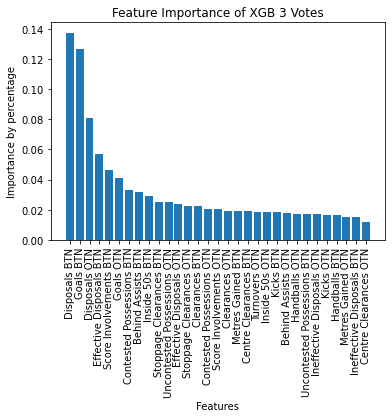

In [35]:
shaoxing.get_feature_importance()

In [36]:
shaoxing.get_analysis('./test')

Time taken to train model: None


,Train,Validation,Test
R2,0.2221,0.1286,0.1196
RMSE,0.1312,0.1389,0.1397
Q4 n 1,40436.0000,8675.0000,8665.0000
Q4 n 2,0.0000,0.0000,0.0000
Q4 n 3,0.0000,0.0000,0.0000
Q4 n 4,937.0000,201.0000,201.0000
Q4 R2 1,0.0000,0.0000,0.0000
Q4 R2 2,NaN,NaN,NaN
Q4 R2 3,NaN,NaN,NaN
Q4 R2 4,0.0000,0.0000,0.0000


,CV Train,CV Test
CV R2,0.215710,0.117109
CV RMSE,0.131764,0.139771


Residuals~X corr 0.08776676797912779 Residuals~X r2 0.007703005561502052 Residuals~X Fstat pval 1.0660088949660504e-49


,corr,r2,Fstat_pval
0,0.042203,0.001781,8.861782e-18
0,0.035195,0.001239,8.021424e-13
0,0.028304,0.000801,8.501083e-09
0,0.024583,0.000604,5.703370e-07
0,0.044222,0.001956,2.274186e-19
0,0.038308,0.001467,6.459865e-15
0,0.036999,0.001369,5.146026e-14
0,0.023439,0.000549,1.858370e-06
0,0.030272,0.000916,7.329560e-10
0,0.023308,0.000543,2.122517e-06


Train Residual Plots
Val Residual Plots
Test Residual Plots


/var/folders/xg/8w_3dndd6l5c3n99vd7vd3f40000gn/T/ipykernel_72266/72587657.py:342: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [37]:
shaoxing.export_residual_plot('Kicks BTN', 'Train', 'test_data')

In [38]:
shaoxing.display_model_analysis_stats()

,Train,Validation,Test
R2,0.2221,0.1286,0.1196
RMSE,0.1312,0.1389,0.1397
Q4 n 1,40436.0000,8675.0000,8665.0000
Q4 n 2,0.0000,0.0000,0.0000
Q4 n 3,0.0000,0.0000,0.0000
Q4 n 4,937.0000,201.0000,201.0000
Q4 R2 1,0.0000,0.0000,0.0000
Q4 R2 2,NaN,NaN,NaN
Q4 R2 3,NaN,NaN,NaN
Q4 R2 4,0.0000,0.0000,0.0000


,CV Train,CV Test
CV R2,0.215710,0.117109
CV RMSE,0.131764,0.139771
